In [1]:
import os.path as osp
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

this_dir = osp.dirname('./')

# Add caffe to PYTHONPATH
caffe_path = osp.join(this_dir, '..', 'caffe-fast-rcnn', 'python')
add_path(caffe_path)

# Add lib to PYTHONPATH
lib_path = osp.join(this_dir, '..', 'lib')
add_path(lib_path)


lib_path = osp.join(this_dir,'mftracker')
add_path(lib_path)

add_path('data/coco/PythonAPI')

#print "add path done..."


In [2]:
import tensorflow as tf
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os, sys, cv2
import argparse
from networks.factory import get_network

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [3]:
label={0: 'bg', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: 'backpack', 26: 'umbrella', 27: 'handbag', 28: 'tie', 29: 'suitcase', 30: 'frisbee', 31: 'skis', 32: 'snowboard', 33: 'sports ball', 34: 'kite', 35: 'baseball bat', 36: 'baseball glove', 37: 'skateboard', 38: 'surfboard', 39: 'tennis racket', 40: 'bottle', 41: 'wine glass', 42: 'cup', 43: 'fork', 44: 'knife', 45: 'spoon', 46: 'bowl', 47: 'banana', 48: 'apple', 49: 'sandwich', 50: 'orange', 51: 'broccoli', 52: 'carrot', 53: 'hot dog', 54: 'pizza', 55: 'donut', 56: 'cake', 57: 'chair', 58: 'couch', 59: 'potted plant', 60: 'bed', 61: 'dining table', 62: 'toilet', 63: 'tv/monitor/display', 64: 'laptop', 65: 'mouse', 66: 'remote', 67: 'keyboard', 68: 'cell phone', 69: 'microwave', 70: 'oven', 71: 'toaster', 72: 'sink', 73: 'refrigerator', 74: 'book', 75: 'clock', 76: 'vase', 77: 'scissors', 78: 'teddy bear', 79: 'hair drier', 80: 'toothbrush'}

CLASSES = []
for i in label:
    CLASSES.append(label[i])

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')



#CLASSES = ('__background__','person','bike','motorbike','car','bus')

def vis_detections(im, class_name, dets,ax, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [10]:
def demo(sess, net, image_name, thresh):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    #im_file = os.path.join('/home/corgi/Lab/label/pos_frame/ACCV/training/000001/',image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')

    CONF_THRESH = thresh
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]): # (CLASSES[:])
        cls_ind += 1 # because we skipped background 
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        print len(dets)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, ax, thresh=CONF_THRESH)


In [5]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    # load network
net = get_network('VGGnet_test')

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/rpn_conv/3x3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/rpn_cls_score:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("rpn_cls_prob_reshape:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_bbox_pred/rpn_bbox_pred:0", shape=(?, ?, ?, 36), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rois:0", shape=(?, 5), dtype=float32)
[<tf.Tensor 'conv5_3/conv5_3:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'rois:0' shape=(?, 5) dtype=float32>]
========== fc_layer =========
========== fc_layer =========
========== fc_layer =========
Tensor("fc7/fc7:0", shape=(?, 4096), dtype=float32)
========== fc_layer =========


In [6]:
#model = './../output/faster_rcnn_end2end/coco_2014_train/VGGnet_fast_rcnn_iter_490000.ckpt'
model = './../output/faster_rcnn_end2end/voc_2007_trainval/VGGnet_fast_rcnn_iter_70000.ckpt'
saver = tf.train.Saver(write_version=tf.train.SaverDef.V1)
saver.restore(sess, model)

#sess.run(tf.initialize_all_variables())

#print '\n\nLoaded network {:s}'.format(args.model)

# Warmup on a dummy image



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/./../VOCdevkit2007/VOC2007/JPEGImages/002424.jpg
Detection took 0.242s for 128 object proposals
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


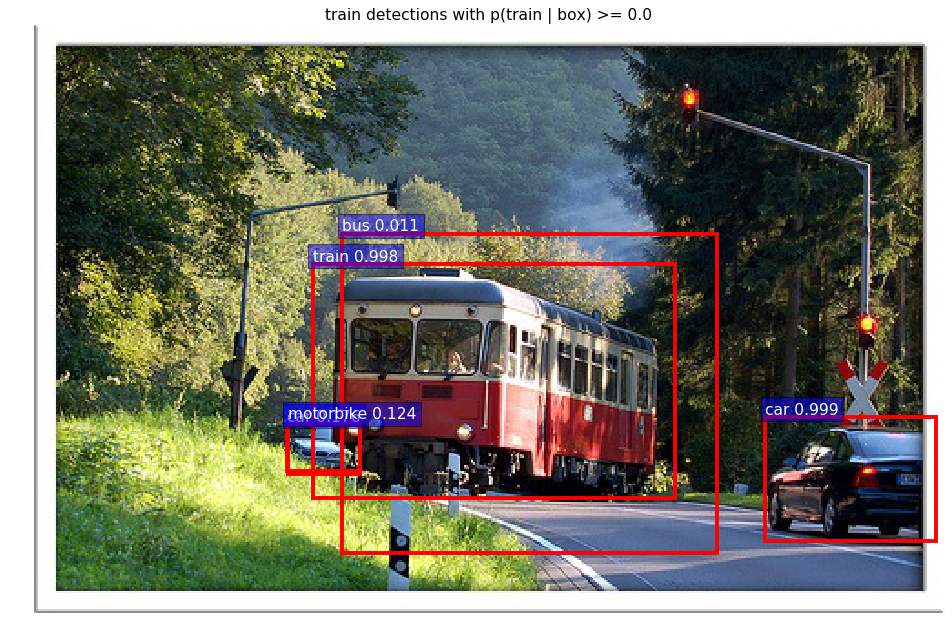

In [11]:
#im = 128 * np.ones((300, 300, 3), dtype=np.uint8)
#for i in xrange(2):
#    _, _= im_detect(sess, net, im)


im_names = ['./../VOCdevkit2007/VOC2007/JPEGImages/002424.jpg']

for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(sess, net, im_name, 0.01)

plt.show()